## ML for Asset Management - Marcos Lopez Prado 

**Date:** 2025-05-29

### Section 6 - Feature Importance Analysis

Consider a researcher interested in modeling a dynamic system as a function of many different candidate variables. 

Only a small subset of those candidate variables are expected to be relevant, however the researcher does not know in advance which.

Researchers should follow the same steps that they would apply to the problem of solving a puzzle: first, isolate the important variables, irrespective of any functional form, and only then try to fit those variables to a particular specification that is consistent with those isolated variables. ML techniques allow us to disentangle the specification search from the variable search.

In this section, we demonstrate that ML provides intuitive and effective tools for researchers who work on the development of theories.

### 6.2 $p$-values

A popular way of expressing a variable’s significance is through its p-value.

The p-value quantifies the probability that, if the true coefficient associated with that variable is zero, we could have obtained a result equal or more extreme than the one we have estimated.

However, a p-value does not measure the probability that neither the null nor the alternative hypothesis is true, or that the data are random.

And a p-value does not measure the size of an effect, or the significance of a result...

**In short**, not a great tool to measure significance.

**Numerical Example:**

Consider a binary random classification problem composed of forty features, where five are informative, thirty are redundant, and five are noise.

The following code implements function getTestData, which generates informative, redundant, and noisy features. 

In [4]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
import seaborn as sns
import statsmodels.api as sm

def getTestData(n_features=100, n_informative=25, n_redundant=25,
                n_samples=10000, random_state=0, sigmaStd=0.0):
    """
    Generate a synthetic classification dataset with informative,
    non-informative, and redundant features.
    """
    np.random.seed(random_state)

    # Generate informative + noise (non-redundant) features
    X, y = make_classification(
        n_samples=n_samples,
        n_features=n_features - n_redundant,
        n_informative=n_informative,
        n_redundant=0,
        shuffle=False,
        random_state=random_state
    )

    # Name informative and noise features
    cols = ['I_' + str(i) for i in range(n_informative)]
    cols += ['N_' + str(i) for i in range(n_features - n_informative - n_redundant)]

    # Convert to DataFrame/Series
    X, y = pd.DataFrame(X, columns=cols), pd.Series(y)

    # Add redundant features as noisy copies of informative ones
    selected = np.random.choice(range(n_informative), size=n_redundant)
    for k, j in enumerate(selected):
        X['R_' + str(k)] = X['I_' + str(j)] + np.random.normal(scale=sigmaStd, size=X.shape[0])

    return X, y

# Generate dataset
X, y = getTestData(n_features=40, n_informative=5, n_redundant=30, n_samples=10000, sigmaStd=0.1)

# Fit logistic regression model
logit_model = sm.Logit(y, X).fit()


Optimization terminated successfully.
         Current function value: 0.380271
         Iterations 7


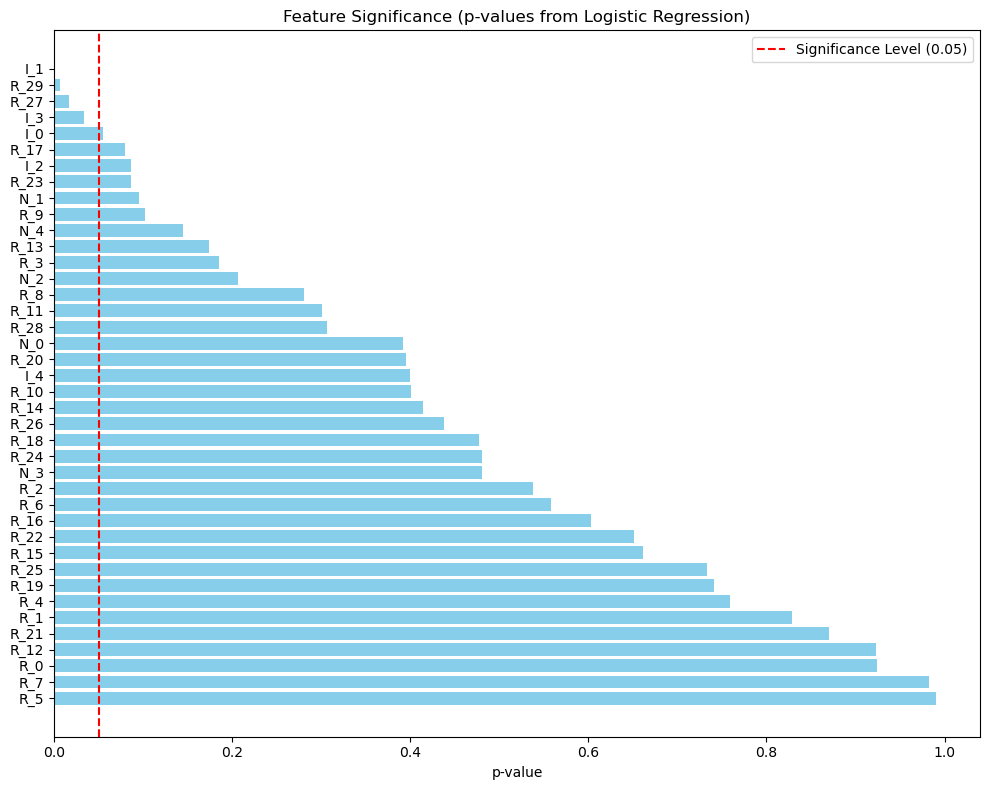

In [5]:
import matplotlib.pyplot as plt

# Get p-values from model
p_values = logit_model.pvalues.sort_values(ascending=True)

# Plot
plt.figure(figsize=(10, 8))
plt.barh(p_values.index, p_values.values, color='skyblue')
plt.axvline(x=0.05, color='red', linestyle='--', label='Significance Level (0.05)')
plt.xlabel("p-value")
plt.title("Feature Significance (p-values from Logistic Regression)")
plt.gca().invert_yaxis()  # most significant at top
plt.legend()
plt.tight_layout()
plt.show()


### 6.2 Ctd.


**Analysis:**

The horizontal bars report the p-values, and the vertical dashed line marks the 5% significance level. Only four out of the thirty-five nonnoise features are deemed statistically significant. Fourteen of the features ranked as least important are not noise. In short, these p-values misrepresent the ground truth.

Unfortunately, financial data sets tend to be highly multicollinear.

### 6.3 Feature Importance:

In this section, we study how two of ML’s feature importance methods address the caveats of p-values, with minimal assumptions, using computational techniques.

Other examples of interpretability methods are accumulated local effects and Shapley values.

### 6.3.1 Mean-Decrease Impurity

Suppose you have a learning sample of size $N$, composed of $F$ features, $\{X_f\}_{f=1,...,F}$ and one label per observation. 

A tree-based classification algorithm splits at each node $t$ its labels into two samples: for a given feature $X_f$, labels in node $t$ associated with a $X_f$ below a threshold $\tau$ are placed in the left sample, and the rest are placed in the right sample. 

For each of these samples, we can evaluate their impurity as the entropy of the distribution of labels, as the Gini index. 

Intuitively, a sample is purest when it contains only labels of one kind and most impure when its labels follow a uniform distribution (max H(X) = log_2|X| - X ~ Unif, thanks 474).

The information gain that results from a split is measured in terms of the resulting reductino in impurity: 

$$\Delta g [t,f] = i[t]-\frac{N^{(0)_t}}{N_t}i[t^{(0)}] - \frac{N^{(1)_t}}{N_t}i[t^{(1)}]$$

Where 

- $i[t]$ is the impurity of labels at node $t$ before the split.

- $i[t^{(0)}]$ is the impurity of labels in the left sample

- $i[t^{(1)}]$ is the impurity of labels in the right sample

At each node t, the classification algorithm evaluates $\Delta g [t,f]$ for various features, determines the optimal threshold that maximises this, and selects the feature f associated with the greatest $\Delta g [t,f]$. 

The classification algorithm continues splitting the samples further until no additional information gains can be produced, or some early-stopping condition is met, such as achieving an impurity below the maximum acceptable limit.

The importance of a feature can be computed as the weighted information gain $\Delta g [t,f]$ across all nodes where that feature was selected.

This tree-based feature importance concept, introduced by Breiman (2001), is known as mean-decrease impurity (MDI). By construction, the MDI value associated with each feature is bounded between 0 and 1, and all combined add up to 1.

For algorithms that combine ensembles of trees, like random forests, we can further estimate the mean and variance of MDI values for each feature across all trees. These mean and variance estimates, along with the central limit theorem, are useful in testing the significance of a feature against a user-defined null hypothesis.

The code below implements an ensemble MDI procedure.

In [7]:
import numpy as np
import pandas as pd

def featImpMDI(fit, featNames):
    """
    Compute feature importance using the Mean Decrease in Impurity (MDI) method
    based on a Bagging ensemble of decision trees.

    Parameters:
    - fit: fitted BaggingClassifier model
    - featNames: list of feature names

    Returns:
    - DataFrame with mean and standard error of feature importances
    """
    # Extract feature importances from each tree
    df0 = {i: tree.feature_importances_ for i, tree in enumerate(fit.estimators_)}
    df0 = pd.DataFrame.from_dict(df0, orient='index')
    df0.columns = featNames

    # Replace zeros with NaN to avoid skewing the average
    df0 = df0.replace(0, np.nan)

    # Compute mean and standard error (CLT)
    imp = pd.concat({
        'mean': df0.mean(),
        'std': df0.std() * df0.shape[0]**-0.5
    }, axis=1)

    # Normalize by sum of means
    imp /= imp['mean'].sum()

    return imp

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

# Generate data
X, y = getTestData(40, 5, 30, 10000, sigmaStd=0.1)

# Define base estimator
base_clf = DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    class_weight='balanced',
    min_weight_fraction_leaf=0
)

# Bagging ensemble
clf = BaggingClassifier(
    estimator=base_clf,
    n_estimators=1000,
    max_features=1.0,
    max_samples=1.0,
    oob_score=False
)

# Fit model and compute importances
fit = clf.fit(X, y)
imp = featImpMDI(fit, featNames=X.columns)



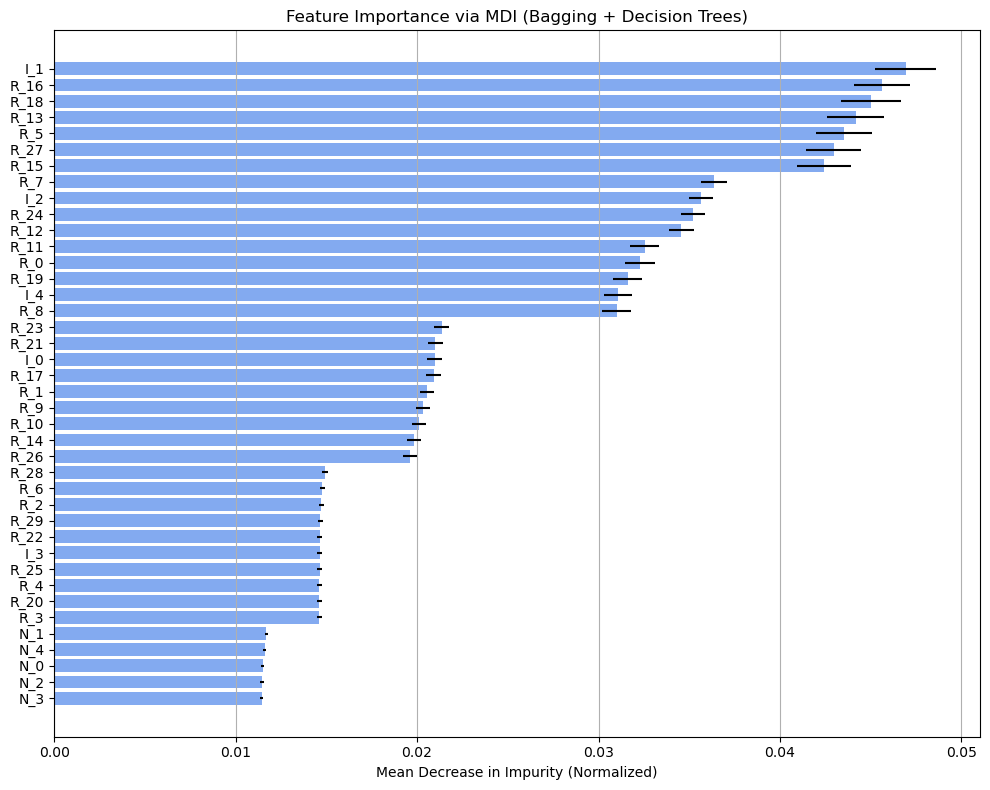

In [8]:
import matplotlib.pyplot as plt

# Sort by mean importance
imp_sorted = imp.sort_values("mean", ascending=True)

# Plot
plt.figure(figsize=(10, 8))
plt.barh(
    imp_sorted.index,
    imp_sorted['mean'],
    xerr=imp_sorted['std'],
    color='cornflowerblue',
    alpha=0.8
)
plt.xlabel("Mean Decrease in Impurity (Normalized)")
plt.title("Feature Importance via MDI (Bagging + Decision Trees)")
plt.grid(axis='x')
plt.tight_layout()
plt.show()

### 6.3.1 Continued:

The horizontal bars indicate the mean of MDI values across 1,000 trees in a random forest, and the lines indicate the standard deviation around that mean. 

MDI does a good job, in the sense that all of the nonnoisy features (either informed or redundant) are ranked higher than the noise features. Still, a small number of nonnoisy features appear to be much more important than their peers.

### 6.3.2 Mean-Decrease Accuracy

A disadvantage of both p-values and MDI is that a variable that appears to be significant for explanatory purposes (in sample) may be irrelevant for forecasting purposes (out of sample). To solve this, we introduce the MDA method.

MDA works as follows:

First it fits a model and computes its cross-validated performance,

Second it computes the cross-validated performance of the same fitted model with the only difference that it shuffels the observations associated with **one** of the features. This gives us one modified cross-validated performance per feature.

Third it dervies the MDA associated with a particular feature by comparing the cross-validated performance before and after shuffling. 

If the feature is important, there should be a significant decay in performance cause by the shuffling as long as the features are independent. When features are not independent, MDA may underestimate the importance of interrelated features.

The following code implements MDA:

In [9]:
import numpy as np
import pandas as pd
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold

def featImpMDA(clf, X, y, n_splits=10):
    """
    Feature importance based on Mean Decrease in Accuracy (MDA),
    using out-of-sample log-loss from K-fold cross-validation.
    
    Parameters:
    - clf: classifier with predict_proba method
    - X: DataFrame of features
    - y: Series of labels
    - n_splits: number of cross-validation splits

    Returns:
    - DataFrame with mean and std feature importance scores
    """
    cvGen = KFold(n_splits=n_splits)
    scr0 = pd.Series(dtype=float)
    scr1 = pd.DataFrame(columns=X.columns)

    for i, (train, test) in enumerate(cvGen.split(X=X)):
        X0, y0 = X.iloc[train], y.iloc[train]
        X1, y1 = X.iloc[test], y.iloc[test]

        fit = clf.fit(X0, y0)
        prob = fit.predict_proba(X1)
        scr0.loc[i] = -log_loss(y1, prob, labels=clf.classes_)

        for j in X.columns:
            X1_ = X1.copy(deep=True)
            np.random.shuffle(X1_[j].values)  # shuffle one feature
            prob_shuffled = fit.predict_proba(X1_)
            scr1.loc[i, j] = -log_loss(y1, prob_shuffled, labels=clf.classes_)

    # Compute relative decrease in performance
    imp = (-1 * scr1).add(scr0, axis=0)
    imp = imp / (-1 * scr1)

    # Aggregate with CLT
    imp = pd.concat({
        'mean': imp.mean(),
        'std': imp.std() * imp.shape[0]**-0.5
    }, axis=1)

    return imp


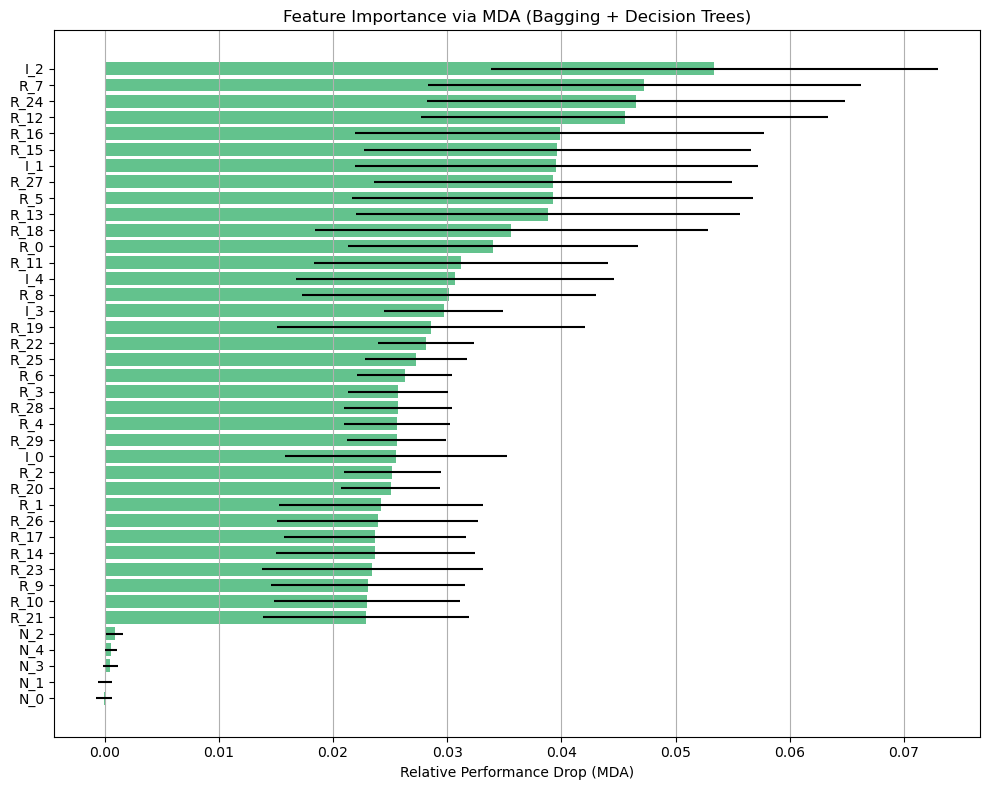

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
import matplotlib.pyplot as plt

# Generate test data
X, y = getTestData(40, 5, 30, 10000, sigmaStd=0.1)

# Define base classifier
base_clf = DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    class_weight='balanced',
    min_weight_fraction_leaf=0
)

clf = BaggingClassifier(
    estimator=base_clf,  # ✅ use 'estimator' if sklearn >= 1.2
    n_estimators=1000,
    max_features=1.0,
    max_samples=1.0,
    oob_score=False
)

# Compute feature importances via MDA
imp = featImpMDA(clf, X, y, n_splits=10)

# --- Plot ---

imp_sorted = imp.sort_values("mean", ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(
    imp_sorted.index,
    imp_sorted['mean'],
    xerr=imp_sorted['std'],
    color='mediumseagreen',
    alpha=0.8
)
plt.xlabel("Relative Performance Drop (MDA)")
plt.title("Feature Importance via MDA (Bagging + Decision Trees)")
plt.grid(axis='x')
plt.tight_layout()
plt.show()


**Analysis:**

First, MDA does a good job overall at separating noise features from the rest. Noise features are ranked last. Second, noise features are also deemed unimportant in magnitude, with MDA values of essentially zero.

Despite its name, MDA does not necessarily rely on accuracy to evaluate the cross-validated performance. MDA can be computed on other performance scores. In fact, in the particular case of finance, accuracy is not a particularly good choice:

The reason is, accuracy scores a classifier in terms of its proportion of correct predictions. This has the disadvantage that probabilities are not taken into account. For example, a classifier may achieve high accuracy even though it made good predictions with low confidence and bad predictions with high confidence. In the following section, we introduce a scoring function that addresses this concern.

### 6.4 Probability-Weighted Accuracy:

In financial applications, a good alternative to accuracy is log-loss/cross-entropy loss. Log-loss scores a classifier in terms of the average log-likelihood of the true labels.

One disadvantage, however, is that log-loss scores are not easy to interpret and compare. A possible solution is to compute the negative average likelihood of the true labels (NegAL): $$NegAL = -N^{-1}\sum^{N-1}_{n=0}\sum^{K-1}_{k=0}y_{n,k}p_{n,k}$$

Where:
- $p_{n,k}$ is the probability associated iwth the prediction n of label k
- $y_{n,k}$ is an indicator function that equals 1 when observation n was assigned label k, 0 o.w.

This is very similar to log-loss, with the difference that it averages likelihoods rather than log-likelihoods, so that NegAL still ranges between 0 and 1.

Alternatively we can define the probability-weighted accuracy (**PWA**) as: $$PWA = \sum^{N-1}_{n=0}y_n(p_n-K^{-1}) / \sum^{N-1}_{n=0}(p_n-K^{-1})$$

Where 
- $p_n = max\{p_{n,k}\}$
- $y_n$ is an indicator function that equals 1 when the predction was correct. 

This is equivalent to standard accuracy when the classifier has absolute conviction in every prediction.

PWA punishes bad predictions made with high confidence more severely than accuracy, but less severely than log-loss.

### 6.5 Substitution Effects

Substitution effects arise when two features share predictive information. These effects can bias thee results from feature importance methods. 

For MDI the importance of two identical features will be halved.

For MDA, two identical featrues may be considered unimportant because the effect of shuffling one may be compensated by the other. 

### 6.5.1 Orthogonalization

Codependence causes substitution effects when evaluating the importance of features. One solution to multicollinearity is to apply PCA on the features, then run MDI or MDA on those principal components. 

### 6.5.2 Cluster Feature Importance

A better approach is to cluster similar features and apply the feature importance analysis at the cluster level. This keeps the results intuitive. 

Here we introduce an algorithm that implements this: **CFI**. This has 2 steps:
1. Finding the number and constituents of the clusters of features
2. Applying the feature importance analysis on groups of similar features.

**Step 1: Features Clustering**

First we project the observed features into a metric space, resulting in matrix $\{X_f\}_{f=1,..,F}$. 

- To do this, one way is to follow the correlation based approach in 4.4.1
- Another way is to apply info-theory concepts (such as Variation of Information) to represent those features in a metric space. Information-theoretic metrics have the advantage of recognizing redundant features that are the result of nonlinear combinations of informative features.

Second we apply a procedure to determine the optimal number and composition of clusters, such as ONC. 

- Remember that ONC finds the optimal number of clusters as well as the composition of those clusters, where each feature belongs to one and only one cluster.

Some silhouette scores may be low due one feature being a combination of multiple features across clusters. This is a problem, because ONC cannot assign one feature to multiple clusters.

In this case, the following transformation may help reduce the multicollinearity of the system:

- For each cluster k = 1, ... , K replace the features included in that cluster with residual features. Where those residual features do not contain information from features *outside* cluster k.

- To be precise: Let $D_k$ be the subset of index features $D = \{1, ... , F\}$ included in cluster k. Then for a given feature $X_i$ where $i \in D_k$, we compute the resiudal feature $\hat{\epsilon_i}$ by fitting $$X_{n,i} = \alpha_i + \sum_{j \in \cup_{l<k}D_l} \beta_{i,j} X_{n,j} + \epsilon_{n,i} $$

Where $n= 1 ,..., N$ is the index of observations per feature. 

One of ther properties of OLS residuals is that they are orthogonal to the regressors. Thus by replacing each feature $X_i$ with its residual equivalent $\hat{\epsilon_i}$, we remove from cluster k the information that is already included in other clusters, while preserving the information that exclusively belongs to cluster k. 

(This transformation isn't necessary if the silhouette scores clearly indicate that features belong to their respective clusters.)

**Step 2: Clustered Importance**

Step 1 identifies the number and composition of the clusters of features. We then use this to apply MDI and MDA on groups of similar features, rather than on individual features. 

For the following we assume partitioned clusters, but it can be applied to hierarchical clusters as well. 

**Clustered MDI**

We compute the clustered MDI as the sum of the MDI values of the features that constitute that cluster.

In [11]:
# Clustered MDI:

def groupMeanStd(df0, clstrs):
    """
    Compute mean and standard error of grouped columns in df0.

    Parameters:
    - df0: DataFrame of feature importances (rows = trees, columns = features)
    - clstrs: Series or dict mapping group index to feature list

    Returns:
    - DataFrame with 'mean' and 'std' of group-wise importance
    """
    out = pd.DataFrame(columns=['mean', 'std'])

    for i, j in clstrs.items():
        df1 = df0[j].sum(axis=1)  # sum importance of features in group
        out.loc['C_' + str(i), 'mean'] = df1.mean()
        out.loc['C_' + str(i), 'std'] = df1.std() * df1.shape[0]**-0.5  # standard error

    return out

# --------------------------------------------
def featImpMDI_Clustered(fit, featNames, clstrs):
    """
    Compute MDI feature importance at the cluster/group level.

    Parameters:
    - fit: Fitted BaggingClassifier or RandomForest model
    - featNames: List of feature names
    - clstrs: Dictionary mapping group index to list of feature names in that group

    Returns:
    - DataFrame with normalized mean and standard error of importances per cluster
    """
    df0 = {i: tree.feature_importances_ for i, tree in enumerate(fit.estimators_)}
    df0 = pd.DataFrame.from_dict(df0, orient='index')
    df0.columns = featNames
    df0 = df0.replace(0, np.nan)  # replace zeros to avoid bias from inactive splits

    imp = groupMeanStd(df0, clstrs)
    imp /= imp['mean'].sum()  # normalize total importance to 1

    return imp



**Clustered MDA**

When computing the clustered MDA we shuffle all of the features that constitute a given cluster.

In [12]:
# Clustered MDA:

import numpy as np
import pandas as pd
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold

def featImpMDA_Clustered(clf, X, y, clstrs, n_splits=10):
    """
    Compute cluster-level MDA feature importance via cross-validated log-loss.

    Parameters:
    - clf: Classifier with predict_proba method
    - X: DataFrame of features
    - y: Target labels
    - clstrs: Dictionary mapping cluster names to lists of feature names
    - n_splits: Number of K-fold splits

    Returns:
    - DataFrame of normalized mean and standard error for each cluster
    """
    cvGen = KFold(n_splits=n_splits)
    scr0 = pd.Series(dtype=float)
    scr1 = pd.DataFrame(columns=clstrs.keys())

    for i, (train, test) in enumerate(cvGen.split(X=X)):
        X0, y0 = X.iloc[train], y.iloc[train]
        X1, y1 = X.iloc[test], y.iloc[test]

        fit = clf.fit(X0, y0)
        prob = fit.predict_proba(X1)
        scr0.loc[i] = -log_loss(y1, prob, labels=clf.classes_)

        for j in scr1.columns:  # each cluster
            X1_ = X1.copy(deep=True)
            for k in clstrs[j]:  # each feature in the cluster
                np.random.shuffle(X1_[k].values)  # shuffle feature
            prob_shuffled = fit.predict_proba(X1_)
            scr1.loc[i, j] = -log_loss(y1, prob_shuffled, labels=clf.classes_)

    # Compute relative importance and normalize
    imp = (-1 * scr1).add(scr0, axis=0)
    imp = imp / (-1 * scr1)

    imp = pd.concat({
        'mean': imp.mean(),
        'std': imp.std() * imp.shape[0]**-0.5
    }, axis=1)

    # Prefix cluster names with 'C_'
    imp.index = ['C_' + str(i) for i in imp.index]

    return imp


### 6.6 Experimental Results:

In this experiment we are going to test the clustered MDI and MDA procedures on the same data set we used on the nonclustered versions of MDI and MDA.

First, we apply the ONC algorithm to the correlation matrix of those features. In a nonexperimental setting, the researcher should denoise and detone the correlation matrix before clustering, as explained in Chapter 2.

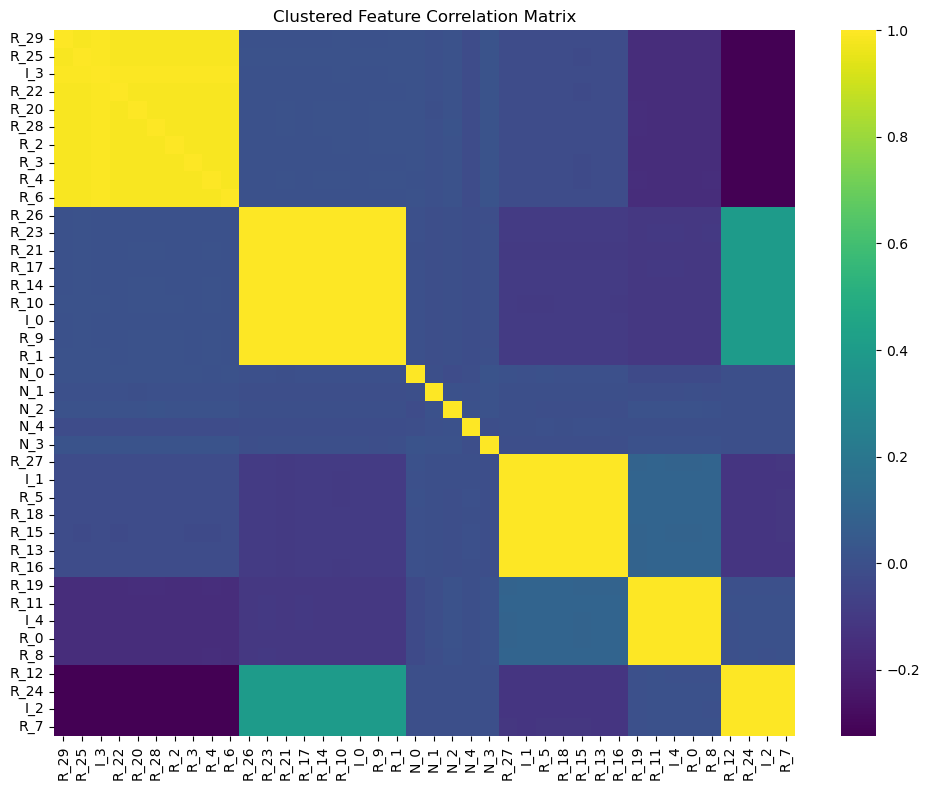

Number of clusters: 6


In [22]:
# Features Clustering:

# Function from section 4:

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples

def clusterKMeansBase(corr0, maxNumClusters=10, n_init=10):
    x = ((1 - corr0.fillna(0)) / 2.)**.5
    silh_best, kmeans_best = pd.Series(), None
    for _ in range(n_init):
        for i in range(2, maxNumClusters + 1):
            kmeans = KMeans(n_clusters=i, n_init=1, random_state=42)
            kmeans = kmeans.fit(x)
            silh = silhouette_samples(x, kmeans.labels_)
            score = np.mean(silh) / np.std(silh)
            if kmeans_best is None or np.isnan(score) or score > np.mean(silh_best) / np.std(silh_best):
                silh_best, kmeans_best = silh, kmeans
    newIdx = np.argsort(kmeans_best.labels_)
    corr1 = corr0.iloc[newIdx, :].iloc[:, newIdx]
    clstrs = {i: corr0.columns[np.where(kmeans_best.labels_ == i)[0]].tolist()
              for i in np.unique(kmeans_best.labels_)}
    silh_series = pd.Series(silh_best, index=x.index)
    return corr1, clstrs, silh_series

# Set random seed for reproducibility
np.random.seed(0)

# Generate dataset
X, y = getTestData(n_features=40, n_informative=5, n_redundant=30, n_samples=10000, sigmaStd=0.1)

# Get correlation matrix and cluster features
corr = X.corr()
corr_0, clstrs, silh = clusterKMeansBase(corr, maxNumClusters=10, n_init=10)

print(f"Number of clusters: {len(clstrs)}")

# Plot the *clustered* correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_0, cmap='viridis')
plt.title("Clustered Feature Correlation Matrix")
plt.tight_layout()
plt.show()


In [23]:
# Apply clustered MDI

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

# Step 1: Base decision tree
base_clf = DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    class_weight='balanced',
    min_weight_fraction_leaf=0
)

# Step 2: Bagging ensemble
clf = BaggingClassifier(
    estimator=base_clf,  
    n_estimators=1000,
    max_features=1.0,
    max_samples=1.0,
    oob_score=False,
    random_state=42
)

# Step 3: Fit the model
fit = clf.fit(X, y)

# Step 4: Compute clustered MDI
imp_clustered_mdi = featImpMDI_Clustered(fit, X.columns, clstrs)


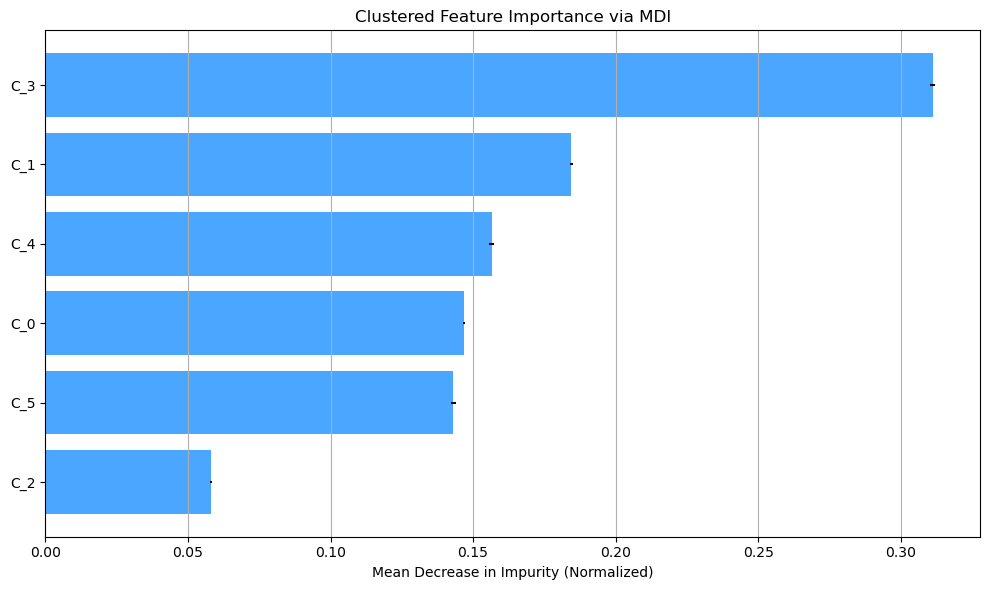

In [24]:
# Sort by importance for better readability
imp_sorted = imp_clustered_mdi.sort_values("mean", ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(
    imp_sorted.index,
    imp_sorted['mean'],
    xerr=imp_sorted['std'],
    color='dodgerblue',
    alpha=0.8
)
plt.xlabel("Mean Decrease in Impurity (Normalized)")
plt.title("Clustered Feature Importance via MDI")
plt.grid(axis='x')
plt.tight_layout()
plt.show()


In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

# Base decision tree classifier
base_clf = DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    class_weight='balanced',
    min_weight_fraction_leaf=0
)

# Bagging classifier with the base estimator
clf = BaggingClassifier(
    estimator=base_clf,  
    n_estimators=1000,
    max_features=1.0,
    max_samples=1.0,
    oob_score=False,
    random_state=0
)

# Apply clustered MDA feature importance
imp = featImpMDA_Clustered(clf, X, y, clstrs, n_splits=10)


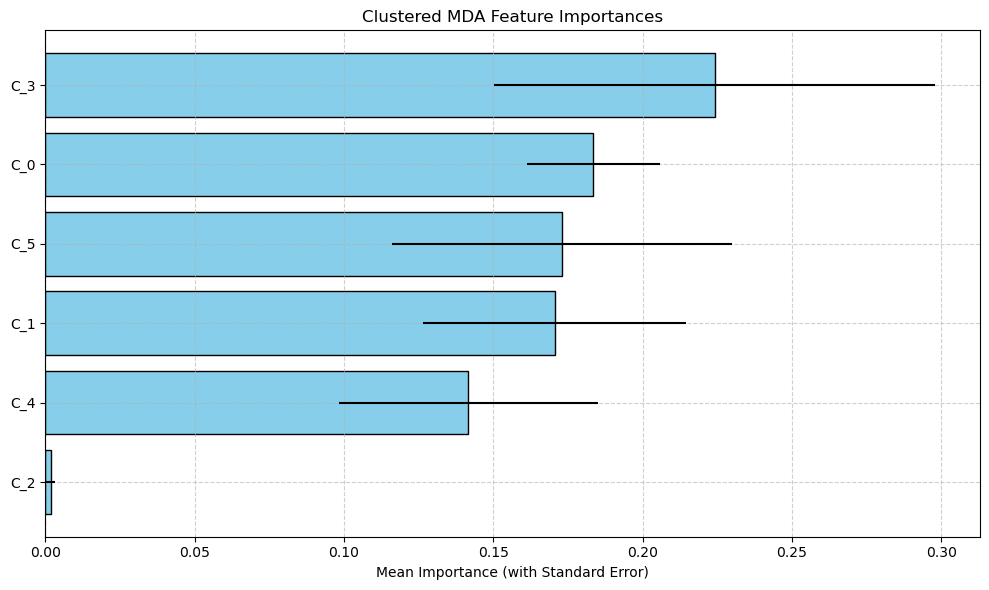

In [28]:
# Sort importances by mean value
imp_sorted = imp.sort_values(by='mean', ascending=True)

# Plot horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(imp_sorted.index, imp_sorted['mean'], xerr=imp_sorted['std'],
         color='skyblue', edgecolor='black')
plt.axvline(0, color='black', linestyle='--')
plt.title("Clustered MDA Feature Importances")
plt.xlabel("Mean Importance (with Standard Error)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### Analysis:

“C_2” is the cluster associated with the noise features, and all other clusters are associated with informative and redundant features. 

This analysis has reached two correct conclusions: 
1.  “C_5” has essentially zero importance, and should be discarded as irrelevant; and 
2.  all other clusters have very similar importance.

### 6.7 Conclusions

While p-values remain a common tool for evaluating the significance of explanatory variables, they suffer from several key flaws. In contrast, machine learning (ML) methods—specifically Mean Decrease Impurity (MDI) and Mean Decrease Accuracy (MDA)—offer robust alternatives that address many of these shortcomings.

MDI and MDA assess feature importance without relying on strong distributional assumptions and do so in a data-driven, cross-validated manner. Clustered variants of these methods further improve reliability by controlling for substitution effects among correlated variables. Unlike classical p-values, ML-based importance scores provide insight independent of any specific model specification, making them especially valuable for theory development.

This suggests that the common belief that ML tools are "black boxes" while classical methods are more transparent is misleading. In fact, ML feature importance metrics can often be more informative and accurate than traditional statistical significance.

Importantly, feature relevance is closely tied to the type of label used. As shown in Section 5, different labeling strategies can change which features matter most. Therefore, it’s wise to evaluate feature importance across multiple label definitions to uncover the most theoretically grounded and practically useful insights.

For instance, you may be indifferent between predicting the sign of the next trend or predicting the sign of the next 5% return, because you can build profitable strategies on either kind of prediction (as long as the feature impor- tance analysis suggests the existence of a strong theoretical connection).
